In [1]:
ENV["LINES"], ENV["COLUMNS"] = 100, 100
using Base.Threads
using BenchmarkTools
using DataFrames
using Distributions
using LinearAlgebra
using Memoization
using Optim
using Printf
using QuadGK
#using RCall
#@rimport stats as R
using Random
Random.seed!(4649373)
using Roots
using SpecialFunctions
using StaticArrays
using StatsBase
using StatsFuns
using StatsPlots
default(fmt = :png, size = (400, 250),
    titlefontsize = 10, guidefontsize=9, plot_titlefontsize = 12)
using SymPy

In [2]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " *
            sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " *
                sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&")
                for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [3]:
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [4]:
function logtick(; xlim=(0.03, 30))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    logticklabel_a = foldl(vcat,
        ([mask[i] ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([mask[i] ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

# logtick()

logtick (generic function with 1 method)

## 必修問題

## 大問1

In [5]:
# 上に書いてある定義の通りのP値の実装

function pvalue_cp(k, n, p)
    bin = Binomial(n, p)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

function pvalue_wilson(k, n, p)
    z = (k - n*p)/√(n*p*(1-p))
    2ccdf(Normal(0, 1), abs(z))
end

function pvalue_bayes(k, n, p; a=1/2)
    beta = Beta(k+a, n-k+a)
    min(1, 2cdf(beta, p), 2ccdf(beta, p))
end

# 後で使うための別のP値の定義

function pvalue_sterne(k, n, p)
    bin = Binomial(n, p)
    # 次はnaiveな定義で計算効率は非常に悪い
    sum(pdf(bin, i) for i in support(bin) if pdf(bin, i) ⪅ pdf(bin, k))
end

function pvalue_wald(k, n, p)
    phat = k/n
    z = (k - n*p)/√(n*phat*(1-phat))
    2ccdf(Normal(0, 1), abs(z))
end

pvalue_wald (generic function with 1 method)

In [6]:
@show k, n, p = 45, 123, 0.5
@show pvalue_cp(k, n, p)
@show pvalue_sterne(k, n, p)
@show pvalue_wilson(k, n, p)
@show pvalue_wald(k, n, p);

(k, n, p) = (45, 123, 0.5) = (45, 123, 0.5)
pvalue_cp(k, n, p) = 0.003731445755098173
pvalue_sterne(k, n, p) = 0.0037314457550981835
pvalue_wilson(k, n, p) = 0.0029250200956793338
pvalue_wald(k, n, p) = 0.0020099961916132864


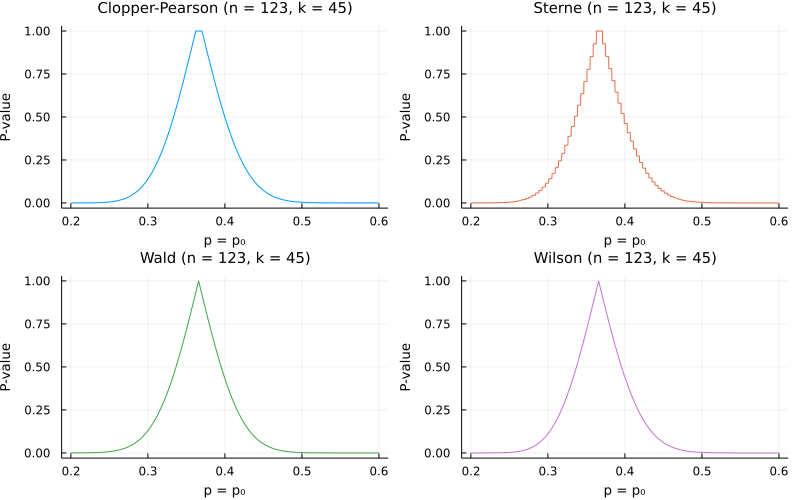

In [7]:
k, n = 45, 123
xlim = (0.2, 0.6)
P1 = plot(p -> pvalue_cp(k, n, p), xlim...;
    label="", title="Clopper-Pearson (n = $n, k = $k)")
P2 = plot(p -> pvalue_sterne(k, n, p), xlim...;
    label="", title="Sterne (n = $n, k = $k)", c=2)
P3 = plot(p -> pvalue_wald(k, n, p), xlim...;
    label="", title="Wald (n = $n, k = $k)", c=3)
P4 = plot(p -> pvalue_wilson(k, n, p), xlim...;
    label="", title="Wilson (n = $n, k = $k)", c=4)
plot(P1, P2, P3, P4; xguide="p = p₀", yguide="P-value", size=(800, 500))

In [8]:
n, k, α = 123, 45, 0.005
[quantile(Beta(k, n-k+1), α/2), quantile(Beta(k+1, n-k), 1-α/2)] |> println


[0.24836987983184594, 0.49579181846516285]


In [9]:
α = 0.005
z = quantile(Normal(0,1), 1 - α/2)

2.807033768343816

In [10]:
n, k = 123, 45
p̂ = k/n
SE = √(p̂*(1 - p̂)/n)
p_L, p_U = p̂ - z*SE, p̂ + z*SE
@show [p_L, p_U]
@show round.([p_L, p_U]; digits=10);

[p_L, p_U] = [0.2439424804010073, 0.4877648366721634]
round.([p_L, p_U]; digits = 10) = [0.2439424804, 0.4877648367]


In [11]:
n, k = 20, 2
p̂ = k/n
SE = √(p̂*(1 - p̂)/n)
p_L, p_U = p̂ - z*SE, p̂ + z*SE
@show [p_L, p_U]
@show round.([p_L, p_U]; digits=4);

[p_L, p_U] = [-0.08830154963462508, 0.28830154963462507]
round.([p_L, p_U]; digits = 4) = [-0.0883, 0.2883]


解答

1, 0.003731445755098173

2, 0.0020099961916132864

3, [0.24836987983184594, 0.49579181846516285]

4, [0.2439424804, 0.4877648367]
 
5, 4

## 大問2

In [12]:
pdflog(dist, x) = exp(logpdf(dist, exp(x)) + x)

@memoize function logmean(dist; a=-1e2, b=1e2)
    quadgk(x -> x * pdflog(dist, x), a, b)[1]
end

@memoize function logvar(dist; a=-1e2, b=1e2)
    μ = logmean(dist; a, b)
    quadgk(x -> (x - μ)^2 * pdflog(dist, x), a, b)[1]
end
logstd(dist; a=-1e2, b=1e2) = √logvar(dist; a, b)

function plot_T(dist, n; L=10^6,
        plot_chi=false, plot_t=false, logsample=false, kwargs...)
    if logsample
        μ, σ = logmean(dist), logstd(dist)
    else
        μ, σ = mean(dist), std(dist)
    end
    println("skewness = ", myskewness(dist), ",  kurtosis = ", mykurtosis(dist))
    
    se = σ/√n
    Z = Vector{Float64}(undef, L)
    S² = Vector{Float64}(undef, L)
    T = Vector{Float64}(undef, L)
    tmp = [Vector{eltype(dist)}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(dist, tmp[threadid()])
        if logsample
            @. X = log(X)
        end
        X̄ = mean(X)
        Z[i] = (X̄ - μ)/se
        S²[i] = var(X)
        T[i] = √n * (X̄ - μ)/√S²[i]
    end
    
    xlim = (-4.0, 5.9)
    bin = range(-6, 6, 150)
    P = stephist(Z; norm=true, xlim, bin, label="Z(μ)")
    plot!(Normal(), xlim...; label="Normal(0,1)", ls=:dash)
    plot!(; xtick=-10:10)
    
    W = .√(S²/σ^2)
    xlim = (0, 3)
    bin = range(quantile.(Ref(W), (0.0, 0.999))..., 150)
    Q = stephist(W; norm=true, xlim, bin, label="√(S²/σ²)")
    if plot_chi
        plot!(Chi(n-1)/√(n-1), xlim...; label="Chi(n-1)/√(n-1)", ls=:dash)
    else
        vline!([1]; label="", ls=:dash)
    end
    plot!(; xtick=range(xlim...; step=0.5))
    
    xlim = (-4.0, 5.9)
    bin = range(-6, 6, 150)
    R = stephist(T; norm=true, xlim, bin, label="T(μ)")
    if plot_t
        plot!(TDist(n-1), xlim...; label="TDist(n-1)", ls=:dash)
    else
        plot!(Normal(), xlim...; label="Normal(0,1)", ls=:dash)
    end
    plot!(; xtick=-10:10)
    
    plot(P, Q, R; size=(800, 200), layout=(1, 3))
    plot_title = if logsample
        "Log of $(distname(dist)), n=$n"
    else
        "$(distname(dist)), n=$n"
    end
    plot!(; plot_title, plot_titlefontsize=10)
    plot!(; kwargs...)
end

#plot_T(Normal(2, 3), 10; plot_chi=true, plot_t=true)
#plot_T(Gamma(2, 3), 10; plot_chi=true, plot_t=true)
#plot_T(Gamma(2, 3), 10; plot_chi=true, plot_t=true, logsample=true)

plot_T (generic function with 1 method)

In [13]:
function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

function show_confint_of_mean(x; μ = mean(x), α = 0.05)
    println("(P-value of hypothesis \"mean = $μ\") = ", pvalue_tdist(x, μ))
    println("($(100(1-α))% confidence interval of mean) = ", confint_tdist(x; α))
end

function plot_confint_of_mean(x; α = 0.10,
        xlim = nothing,
        plot_pvaluefunc = false,
        xtick=50:10:125, kwargs...)
    n = length(x)
    if isnothing(xlim)
        a, b = extrema(x)
        a, b = a - 0.05(b-a), b + 0.05(b-a)
    else
        a, b = xlim
    end
    confidence_interval = confint_tdist(x; α)
    if plot_pvaluefunc
        scatter(x, fill(-0.05, n); label="", msc=:auto, alpha=0.7)
        plot!(μ -> pvalue_tdist(x, μ), a, b; label="", c=2)
        plot!(confidence_interval, fill(α, 2); label="", lw=3, c=:red)
        plot!(; ylim=(-0.1, 1.02), ytick=0:0.1:1, yguide="P-value")
        title!("P-value function and $(100(1-α))% conf. int. of mean for data of size n=$n")
        plot!(; size=(600, 200), leftmargin=4Plots.mm)
    else
        scatter(x, fill(-0.05, n); label="", msc=:auto, alpha=0.7)
        plot!(confidence_interval, fill(0.06, 2); label="", lw=6, c=:red)
        plot!(; ylim=(-0.1, 0.12), yaxis=false, ytick=false)
        title!("$(100(1-α))% confidence interval of mean for data of size n=$n")
        plot!(; size=(600, 60))
    end
    plot!(; xlim=(a, b), xtick)
    plot!(; kwargs...)
end

plot_confint_of_mean (generic function with 1 method)

In [14]:
x = [80, 111, 69, 72, 123, 126, 92, 91, 45, 67, 114]

11-element Vector{Int64}:
  80
 111
  69
  72
 123
 126
  92
  91
  45
  67
 114

In [15]:
x̄=mean(x)

90.0

In [16]:
s2=var(x)

682.6

In [17]:
x = [80, 111, 69, 72, 123, 126, 92, 91, 45, 67, 114]
n = length(x)
x̄ = mean(x)
s² = var(x)

μ = 105
t_value = (x̄ - μ)/√(s²/n)
P_value = 2ccdf(TDist(n-1), abs(t_value))

α = 0.10
c = quantile(TDist(n-1), 1 - α/2)
confidence_interval = [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]

@show x n x̄ s²
println()
@show t_value P_value
println()
@show α c confidence_interval;

x = [80, 111, 69, 72, 123, 126, 92, 91, 45, 67, 114]
n = 11
x̄ = 90.0
s² = 682.6

t_value = -1.9041644801378617
P_value = 0.08602945945697997

α = 0.1
c = 1.8124611228116756
confidence_interval = [75.72239051523175, 104.27760948476825]


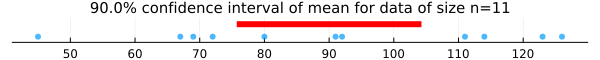

In [18]:
plot_confint_of_mean(x; α)

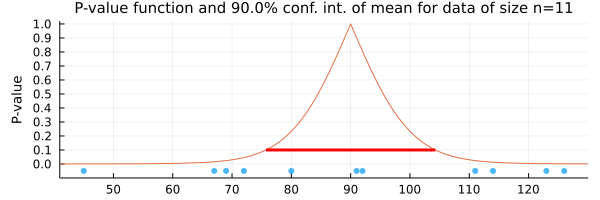

In [19]:
plot_confint_of_mean(x; plot_pvaluefunc=true)

## 解答

1, xbar= 90.0

2, s2= 682.6

3, P_value = 0.08602945945697997

4, confidence_interval = [75.72239051523175, 104.27760948476825]

5, 1


## 大問3

コードは大問8にある

pvalue_rr_wald(a, b, c, d; ρ = 0.9) = 0.03608976031307245

pvalue_or_wald(a, b, c, d; ω = 0.9) = 0.030066296229886037

confint_rr_wald(a, b, c, d; α = 0.05) = [0.3363886834579713, 0.870795692322426]

confint_or_wald(a, b, c, d; α = 0.05) = [0.288799214494071, 0.8496230536999794]

5, 1

## 大問4

In [20]:
# 確率分布を扱う場合には常に以下を前もって実行しておく.

using Distributions

# t値の計算の仕方 (デフォルトで Δμ = 0 にしておく)

function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

# 自由度 ν の計算の仕方

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

# P値の計算の仕方

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

# 信頼区間の計算の仕方 (デフォルトでは α = 0.05 にしておく)

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [21]:
x = [162.0, 221.5, 259.3, 306.8, 184.6, 181.9, 154.8, 147.6, 240.8, 243.5,
209.3, 270.0, 170.4, 183.0, 236.7, 173.4, 212.6, 237.3, 269.4, 211.8];
y = [101.7, 198.0, 276.2, 120.6, 204.1, 183.6, 316.8, 167.7, 291.4, 150.1,
271.2, 258.4, 200.1, 111.4, 110.3, 178.3, 167.9, 141.3, 185.6, 58.2,
220.1, 282.8, 139.5, 80.8, 107.0, 177.9, 220.2, 219.7, 195.6, 116.3];

In [22]:
@show degree_of_freedom_welch(x, y)

degree_of_freedom_welch(x, y) = 47.998721581675596


47.998721581675596

In [23]:
pval1 = pvalue_welch(x, y; Δμ = 0)

0.04594695742760926

In [24]:
pval2 = pvalue_welch(x, y; Δμ = 65)

0.04070350839019126

In [25]:
ci3 = confint_welch(x, y; α = 0.05)
print(ci3)

[0.601018722054544, 63.54898127794549]

xlim = confint_welch(x, y; α = 0.05) = [0.601018722054544, 63.54898127794549]


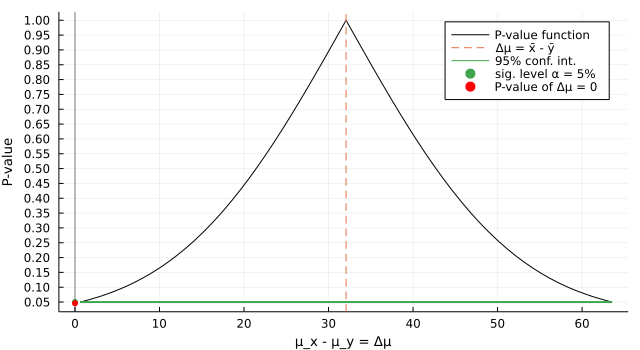

In [26]:
@show xlim = confint_welch(x, y; α=0.05)
plot(Δμ -> pvalue_welch(x, y; Δμ), xlim...; label="P-value function", c=:black)
vline!([mean(x) - mean(y)]; label="Δμ = x̄ - ȳ", ls=:dash, c=2)
plot!(ci3, fill(0.05, 2); label="95% conf. int.", lw=2, c=3)
scatter!([0], [0.05]; label="sig. level α = 5%", c=3, msc=:auto)
vline!([0]; label="", lw=0.5, c=:black)
scatter!([0], [pval1]; label="P-value of Δμ = 0", c=:red, msc=:auto)
plot!(xguide="μ_x - μ_y = Δμ", yguide="P-value")
plot!(ytick=0:0.05:1)
plot!(size=(640, 350))

解答

1,47.998721581675596

2, 0.04594695742760926

3, 0.04070350839019126

4, [0.601018722054544, 63.54898127794549]

5, 4

## 大問5

a 0 

b 1 

c 1

d 0

e 1

f 1

g 1   0??? 差じゃなくて比

h 1

i 1

j 0 

k 0

l 1

m 1

n 1

o 1

p 0

q 1

r 1   00??

s 0

t 1 0??


## 必修ではない問題

## 大問6

In [27]:
x = [
61.1, 62.6, 64.1, 65.4, 66.5, 67.4, 67.9, 68.2, 68.1, 67.8,
67.1, 66.2, 65.0, 63.6, 62.1, 60.5, 58.9, 57.4, 55.9, 54.6,
53.5, 52.6, 52.1, 51.8, 51.9, 58.2, 57.3, 56.5, 55.6, 54.7,
61.1, 60.0, 59.0, 58.0, 57.0, 57.0, 57.2, 57.5, 57.7, 58.0,
51.9, 51.6, 51.4, 51.2, 51.0, 51.0, 52.0, 53.0, 54.0, 55.0,
64.0, 63.2, 62.2, 61.5, 61.3, 61.8, 62.8, 63.7, 64.2, 64.0,
58.5, 57.7, 56.7, 56.0, 55.8, 56.3, 57.3, 58.2, 58.7, 58.5,
58.5, 57.7, 56.7, 56.0, 55.8, 56.3, 57.3, 58.2, 58.7, 58.5,
62.5, 62.1, 61.6, 61.3, 61.4, 61.7, 62.2, 62.6, 62.7, 62.5,
64.0, 64.3, 64.0, 63.2, 62.5, 62.5, 62.8, 62.5, 61.8, 61.0,
65.0, 66.2, 67.5, 68.8, 70.0, 60.0, 58.8, 57.5, 56.2, 55.0,
64.5, 65.6, 66.8, 67.9, 69.0, 59.5, 58.1, 56.8, 55.4, 54.0,
65.5, 66.9, 68.2, 69.6, 71.0, 60.5, 59.4, 58.2, 57.1, 56.0,
];
y = [
239.1, 239.5, 237.3, 232.8, 226.0, 217.2, 206.7, 195.0, 182.5, 169.6,
156.9, 144.9, 134.0, 124.6, 117.1, 111.9, 108.9, 108.5, 110.7, 115.2,
122.0, 130.8, 141.3, 153.0, 165.5, 216.3, 209.3, 202.3, 195.3, 188.3,
239.1, 240.9, 242.7, 244.5, 246.3, 246.3, 238.3, 230.3, 222.3, 214.3,
165.5, 173.7, 181.9, 190.1, 198.3, 198.3, 196.3, 194.3, 192.3, 190.3,
206.0, 207.5, 203.6, 196.2, 188.7, 184.6, 185.8, 191.8, 199.8, 206.0,
162.0, 163.5, 159.6, 152.2, 144.7, 140.6, 141.8, 147.8, 155.8, 162.0,
162.0, 163.5, 159.6, 152.2, 144.7, 140.6, 141.8, 147.8, 155.8, 162.0,
162.0, 163.6, 162.6, 159.5, 155.6, 152.9, 152.5, 154.8, 158.5, 162.0,
166.0, 160.0, 154.0, 151.5, 154.0, 154.0, 148.0, 142.0, 139.5, 142.0,
174.0, 184.0, 194.0, 204.0, 214.0, 134.0, 124.0, 114.0, 104.0, 94.0,
178.0, 189.0, 200.0, 211.0, 222.0, 138.0, 129.0, 120.0, 111.0, 102.0,
170.0, 179.0, 188.0, 197.0, 206.0, 130.0, 119.0, 108.0, 97.0, 86.0,
];

In [28]:
x̄=mean(x)   

60.15

In [29]:
sx²=var(x)

23.696472868217057

In [30]:
ȳ=mean(y)

169.95

In [31]:
sy²=var(y)

1500.6981782945736

In [32]:
sxy=cov(x,y)

51.99949612403102

In [33]:
# プロット用函数
function plot_ols(x, y, α̂, β̂; xlim=nothing, ylim=nothing,
    title="data and regression line", kwargs...)
a, b = extrema(x)
isnothing(xlim) && (xlim = (a - 0.1(b-a), b + 0.1(b-a)))
scatter(x, y; label="", msw=0)
plot!(x -> α̂ + β̂*x, xlim...; label="", lw=2)
plot!(; xlabel="x", ylabel="y", msw=0)
plot!(; size=(400, 300))
plot!(; title, kwargs...)
end

plot_ols (generic function with 1 method)

In [34]:
function solve_anscombe(x, y;title)
    
@show x̄ = mean(x)
@show ȳ = mean(y)
@show sx² = var(x)*129/130
@show sy² = var(y)*129/130
@show sxy = cov(x, y)*129/130
β̂ = sxy/sx²
α̂ = ȳ - β̂*x̄
σ̂ = √((n - 1)/n*(sx²*sy² - sxy^2)/sx²)
σ̂²=(sx²*sy² - sxy^2)/sx²
@show α̂ β̂ σ̂  σ̂²

plot_ols(x, y, α̂, β̂)
end

solve_anscombe (generic function with 1 method)

x̄ = mean(x) = 60.15
ȳ = mean(y) = 169.95
sx² = (var(x) * 129) / 130 = 23.51419230769231
sy² = (var(y) * 129) / 130 = 1489.154346153846
sxy = (cov(x, y) * 129) / 130 = 51.59950000000001
α̂ = 37.956951530090635
β̂ = 2.1943981458006543
σ̂ = 35.367222871795825
σ̂² = 1375.9244990296054


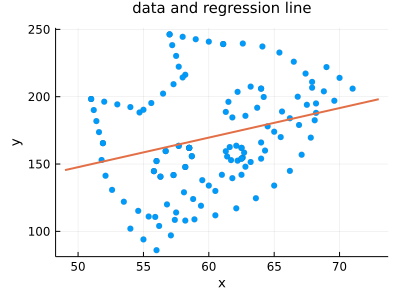

In [35]:
PA1 = solve_anscombe(x, y , title="")

In [36]:
@show sx² = var(x)
@show sy² = var(y)
@show sxy = cov(x, y);

sx² = var(x) = 23.696472868217057
sy² = var(y) = 1500.6981782945736
sxy = cov(x, y) = 51.99949612403102


## 解答

xbar=60.15

ybar=169.95

#  sigma2_x=23.696472868217057

# sigma2_y=1500.6981782945736

# sigma_xy=51.99949612403102

betahat0=37.956951530090635

betahat1=2.1943981458006543
# sigmahat2=1317.26105139656

## 大問7

## 解答
__cat__

## 大問8  

In [37]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " *
            sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " *
                sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&")
                for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [38]:
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [39]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [40]:
@show confint_or_wald(0, 1, 1, 1) confint_or_wald(1e-4, 1, 1, 1)
@show confint_or_wald(1, 0, 1, 1) confint_or_wald(1, 1e-4, 1, 1)
@show confint_or_wald(1, 1, 0, 1) confint_or_wald(1, 1, 1e-4, 1)
@show confint_or_wald(1, 1, 1, 0) confint_or_wald(1, 1, 1, 1e-4)
@show confint_or_wald(0, 0, 1, 1) confint_or_wald(1e-4, 1e-4, 1, 1)
@show confint_or_wald(1, 1, 0, 0) confint_or_wald(1, 1, 1e-4, 1e-4)
@show confint_or_wald(0, 1, 0, 1) confint_or_wald(1e-4, 1, 1e-4, 1)
@show confint_or_wald(1, 0, 1, 0) confint_or_wald(1, 1e-4, 1, 1e-4);

confint_or_wald(0, 1, 1, 1) = [0.0, Inf]
confint_or_wald(0.0001, 1, 1, 1) = [7.363403724036157e-90, 1.3580675968312418e81]
confint_or_wald(1, 0, 1, 1) = [0.0, Inf]
confint_or_wald(1, 0.0001, 1, 1) = [7.363403724036156e-82, 1.3580675968312418e89]
confint_or_wald(1, 1, 0, 1) = [0.0, Inf]
confint_or_wald(1, 1, 0.0001, 1) = [7.363403724036156e-82, 1.3580675968312418e89]
confint_or_wald(1, 1, 1, 0) = [0.0, Inf]
confint_or_wald(1, 1, 1, 0.0001) = [7.363403724036157e-90, 1.3580675968312418e81]
confint_or_wald(0, 0, 1, 1) = [0.0, Inf]
confint_or_wald(0.0001, 0.0001, 1, 1) = [4.1295675438516624e-121, 2.4215610699693177e120]
confint_or_wald(1, 1, 0, 0) = [0.0, Inf]
confint_or_wald(1, 1, 0.0001, 0.0001) = [4.1295675438516624e-121, 2.4215610699693177e120]
confint_or_wald(0, 1, 0, 1) = [0.0, Inf]
confint_or_wald(0.0001, 1, 0.0001, 1) = [4.1295675438516624e-121, 2.4215610699693177e120]
confint_or_wald(1, 0, 1, 0) = [0.0, Inf]
confint_or_wald(1, 0.0001, 1, 0.0001) = [4.1295675438516624e-121, 2.421561

In [41]:
riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [42]:
@show confint_rr_wald(0, 1, 1, 1) confint_rr_wald(1e-4, 1, 1, 1)
@show confint_rr_wald(1, 0, 1, 1) confint_rr_wald(1, 1e-4, 1, 1)
@show confint_rr_wald(1, 1, 0, 1) confint_rr_wald(1, 1, 1e-4, 1)
@show confint_rr_wald(1, 1, 1, 0) confint_rr_wald(1, 1, 1, 1e-4)
@show confint_rr_wald(0, 0, 1, 1) confint_rr_wald(1e-4, 1e-4, 1, 1)
@show confint_rr_wald(1, 1, 0, 0) confint_rr_wald(1, 1, 1e-4, 1e-4)
@show confint_rr_wald(0, 1, 0, 1) confint_rr_wald(1e-4, 1, 1e-4, 1)
@show confint_rr_wald(1, 0, 1, 0) confint_rr_wald(1, 1e-4, 1, 1e-4);

confint_rr_wald(0, 1, 1, 1) = [0.0, Inf]
confint_rr_wald(0.0001, 1, 1, 1) = [1.5239118697601845e-89, 2.62429881894243e81]
confint_rr_wald(1, 0, 1, 1) = [0.5001953065198115, 7.996876315834783]
confint_rr_wald(1, 0.0001, 1, 1) = [0.5000759918604454, 7.997184798065742]
confint_rr_wald(1, 1, 0, 1) = [0.0, Inf]
confint_rr_wald(1, 1, 0.0001, 1) = [3.810541668433138e-82, 6.562059262373016e88]
confint_rr_wald(1, 1, 1, 0) = [0.12504882662995287, 1.9992190789586957]
confint_rr_wald(1, 1, 1, 0.0001) = [0.12504400301489435, 1.999696078749301]
confint_rr_wald(0, 0, 1, 1) = [0.0, Inf]
confint_rr_wald(0.0001, 0.0001, 1, 1) = [6.426171133615772e-61, 1.5561365846124554e60]
confint_rr_wald(1, 1, 0, 0) = [0.0, Inf]
confint_rr_wald(1, 1, 0.0001, 0.0001) = [6.426171133615772e-61, 1.5561365846124554e60]
confint_rr_wald(0, 1, 0, 1) = [0.0, Inf]
confint_rr_wald(0.0001, 1, 0.0001, 1) = [4.245626444711269e-121, 2.3553650162644178e120]
confint_rr_wald(1, 0, 1, 0) = [1.0, 1.0]
confint_rr_wald(1, 0.0001, 1, 0.0001

In [43]:
# 警告: 以下の実装の精度は低い. 改良の仕方が
# 
# Kenneth J. Rothman, Sander Greenland, and Timothy L. Lash
# Modern Epistemology, Third Edition, 2008, 888 pages
#
# の
#
# Chapter 14. Instroduction to Categorical Statistics
# Section. Two Study Groups: Large-Sample Methods, pp.299-300
#
# に書いてある. そこでは, 次の文献が引用されている:
#
# Guangyong Zou and Allan Donner
# A simple alternative confidence interval for the difference between two proportions
# Controlled Clinical Trials, Volume 25, Issue 1, February 2004, Pages 3-12
# https://doi.org/10.1016/j.cct.2003.08.010
#
# Zou-Donnerの信頼区間に対応するP値函数の実装については
#
# https://github.com/genkuroki/public/blob/main/0033/probability%20of%20alpha%20error%20of%20Zou-Donner.ipynb
#
# を参照せよ.

In [44]:
riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m) + safediv(q̂*(1-q̂), n))
end

function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

In [45]:
@show confint_rd_wald(0, 1, 1, 1) confint_rd_wald(1e-4, 1, 1, 1)
@show confint_rd_wald(1, 0, 1, 1) confint_rd_wald(1, 1e-4, 1, 1)
@show confint_rd_wald(1, 1, 0, 1) confint_rd_wald(1, 1, 1e-4, 1)
@show confint_rd_wald(1, 1, 1, 0) confint_rd_wald(1, 1, 1, 1e-4)
@show confint_rd_wald(0, 0, 1, 1) confint_rd_wald(1e-4, 1e-8, 1, 1)
@show confint_rd_wald(1, 1, 0, 0) confint_rd_wald(1, 1, 1e-4, 1e-8)
@show confint_rd_wald(0, 1, 0, 1) confint_rd_wald(1e-4, 1, 1e-8, 1)
@show confint_rd_wald(1, 0, 1, 0) confint_rd_wald(1, 1e-4, 1, 1e-8);

confint_rd_wald(0, 1, 1, 1) = [-1.1929519121748402, 0.1929519121748402]
confint_rd_wald(0.0001, 1, 1, 1) = [-1.1931289644203495, 0.19332894442234927]
confint_rd_wald(1, 0, 1, 1) = [-0.1929519121748402, 1.1929519121748402]
confint_rd_wald(1, 0.0001, 1, 1) = [-0.19332894442234927, 1.1931289644203495]
confint_rd_wald(1, 1, 0, 1) = [-0.1929519121748402, 1.1929519121748402]
confint_rd_wald(1, 1, 0.0001, 1) = [-0.19332894442234927, 1.1931289644203495]
confint_rd_wald(1, 1, 1, 0) = [-1.1929519121748402, 0.1929519121748402]
confint_rd_wald(1, 1, 1, 0.0001) = [-1.1931289644203495, 0.19332894442234927]
confint_rd_wald(0, 0, 1, 1) = [-1.1929519121748402, 0.1929519121748402]
confint_rd_wald(0.0001, 1.0e-8, 1, 1) = [-1.5786785827129024, 2.5784786027109026]
confint_rd_wald(1, 1, 0, 0) = [-0.1929519121748402, 1.1929519121748402]
confint_rd_wald(1, 1, 0.0001, 1.0e-8) = [-2.5784786027109026, 1.5786785827129024]
confint_rd_wald(0, 1, 0, 1) = [0.0, 0.0]
confint_rd_wald(0.0001, 1, 1.0e-8, 1) = [-0.0194977

In [46]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [47]:
@show confint_or_pearson_chisq(0, 1, 1, 1) confint_or_pearson_chisq(1e-4, 1, 1, 1)
@show confint_or_pearson_chisq(1, 0, 1, 1) confint_or_pearson_chisq(1, 1e-4, 1, 1)
@show confint_or_pearson_chisq(1, 1, 0, 1) confint_or_pearson_chisq(1, 1, 1e-4, 1)
@show confint_or_pearson_chisq(1, 1, 1, 0) confint_or_pearson_chisq(1, 1, 1, 1e-4)
@show confint_or_pearson_chisq(0, 0, 1, 1) confint_or_pearson_chisq(1e-4, 1e-4, 1, 1)
@show confint_or_pearson_chisq(1, 1, 0, 0) confint_or_pearson_chisq(1, 1, 1e-4, 1e-4)
@show confint_or_pearson_chisq(0, 1, 0, 1) confint_or_pearson_chisq(1e-4, 1, 1e-4, 1)
@show confint_or_pearson_chisq(1, 0, 1, 0) confint_or_pearson_chisq(1, 1e-4, 1, 1e-4);

confint_or_pearson_chisq(0, 1, 1, 1) = [0.0, 11.137973937616904]
confint_or_pearson_chisq(0.0001, 1, 1, 1) = [2.602261452525905e-9, 11.140095739591606]
confint_or_pearson_chisq(1, 0, 1, 1) = [0.08978293589129746, Inf]
confint_or_pearson_chisq(1, 0.0001, 1, 1) = [0.08976583535507918, 3.842811409403394e8]
confint_or_pearson_chisq(1, 1, 0, 1) = [0.08978293589129746, Inf]
confint_or_pearson_chisq(1, 1, 0.0001, 1) = [0.08976583535507918, 3.842811409403394e8]
confint_or_pearson_chisq(1, 1, 1, 0) = [0.0, 11.137973937616904]
confint_or_pearson_chisq(1, 1, 1, 0.0001) = [2.602261452525905e-9, 11.140095739591601]
confint_or_pearson_chisq(0, 0, 1, 1) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 0.0001, 1, 1) = [1.3012947051505169e-5, 76846.54337277808]
confint_or_pearson_chisq(1, 1, 0, 0) = [0.0, Inf]
confint_or_pearson_chisq(1, 1, 0.0001, 0.0001) = [1.3012947051505169e-5, 76846.54337277808]
confint_or_pearson_chisq(0, 1, 0, 1) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 1, 0.0001, 1) = [1.3012

In [48]:
# Cornfeild (1956), p.139, (4.2) と比較せよ.
a, b, c, d = 3, 11, 60, 32
@show confint_or_wald(a, b, c, d)
@show confint_or_pearson_chisq(a, b, c, d)
@show confint_or_pearson_chisq(a, b, c, d; correction=0.5);

confint_or_wald(a, b, c, d) = [0.037829803607039435, 0.5592686923030045]
confint_or_pearson_chisq(a, b, c, d) = [0.04084291410483445, 0.5253472140108638]
confint_or_pearson_chisq(a, b, c, d; correction = 0.5) = [0.02962955731952911, 0.6228119542455192]


In [49]:
function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    RRhat = riskratiohat(a, b, c, d)
    if a == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif c == 0
        [exp(find_zero(f, 0.0)), Inf]
    elseif b == 0
        [0.0, exp(find_zero(f, log(2RRhat)))]
    elseif d == 0
        [exp(find_zero(f, log(RRhat/2))), Inf]
    else
        ρ_L, ρ_U = RRhat/2, 2RRhat
        [exp(find_zero(f, log(ρ_L))), exp(find_zero(f, log(ρ_U)))]
    end
end

confint_rr_pearson_chisq (generic function with 1 method)

In [50]:
@show confint_rr_pearson_chisq(0, 1, 1, 1) confint_rr_pearson_chisq(1e-4, 1, 1, 1)
@show confint_rr_pearson_chisq(1, 0, 1, 1) confint_rr_pearson_chisq(1, 1e-4, 1, 1)
@show confint_rr_pearson_chisq(1, 1, 0, 1) confint_rr_pearson_chisq(1, 1, 1e-4, 1)
@show confint_rr_pearson_chisq(1, 1, 1, 0) confint_rr_pearson_chisq(1, 1, 1, 1e-4)
@show confint_rr_pearson_chisq(0, 0, 1, 1) confint_rr_pearson_chisq(1e-4, 1e-4, 1, 1)
@show confint_rr_pearson_chisq(1, 1, 0, 0) confint_rr_pearson_chisq(1, 1, 1e-4, 1e-4)
@show confint_rr_pearson_chisq(0, 1, 0, 1) confint_rr_pearson_chisq(1e-4, 1, 1e-4, 1)
@show confint_rr_pearson_chisq(1, 0, 1, 0) confint_rr_pearson_chisq(1, 1e-4, 1, 1e-4);

confint_rr_pearson_chisq(0, 1, 1, 1) = [0.0, 4.10417860525958]
confint_rr_pearson_chisq(0.0001, 1, 1, 1) = [5.205303607358693e-9, 4.104616767401084]
confint_rr_pearson_chisq(1, 0, 1, 1) = [0.0, 10.578517350254106]
confint_rr_pearson_chisq(1, 0.0001, 1, 1) = [0.32665454735880284, 10.577873776111911]
confint_rr_pearson_chisq(1, 1, 0, 1) = [0.2436541135706135, Inf]
confint_rr_pearson_chisq(1, 1, 0.0001, 1) = [0.24362810383225364, 1.9211175282574818e8]
confint_rr_pearson_chisq(1, 1, 1, 0) = [0.09453120573423061, Inf]
confint_rr_pearson_chisq(1, 1, 1, 0.0001) = [0.0945369571584704, 3.0613380652042177]
confint_rr_pearson_chisq(0, 0, 1, 1) = [0.0, Inf]
confint_rr_pearson_chisq(0.0001, 0.0001, 1, 1) = [2.602945936963888e-5, 9.681923544184194]
confint_rr_pearson_chisq(1, 1, 0, 0) = [0.0, Inf]
confint_rr_pearson_chisq(1, 1, 0.0001, 0.0001) = [0.10328526097487344, 38418.00883361873]
confint_rr_pearson_chisq(0, 1, 0, 1) = [0.0, Inf]
confint_rr_pearson_chisq(0.0001, 1, 0.0001, 1) = [1.3016851156610

In [51]:
_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function confint_or_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_sterne (generic function with 1 method)

In [52]:
@show confint_or_sterne(0, 10, 10, 10) confint_or_pearson_chisq(1e-4, 10, 10, 10)
@show confint_or_sterne(10, 0, 10, 10) confint_or_pearson_chisq(10, 1e-4, 10, 10)
@show confint_or_sterne(10, 10, 0, 10) confint_or_pearson_chisq(10, 10, 1e-4, 10)
@show confint_or_sterne(10, 10, 10, 0) confint_or_pearson_chisq(10, 10, 10, 1e-4)
@show confint_or_sterne(0, 0, 10, 10) confint_or_pearson_chisq(1e-4, 1e-4, 10, 10)
@show confint_or_sterne(10, 10, 0, 0) confint_or_pearson_chisq(10, 10, 1e-4, 1e-4)
@show confint_or_sterne(0, 10, 0, 10) confint_or_pearson_chisq(1e-4, 10, 1e-4, 10)
@show confint_or_sterne(10, 0, 10, 0) confint_or_pearson_chisq(10, 1e-4, 10, 1e-4);

confint_or_sterne(0, 10, 10, 10) = [0.0, 0.5431888559914949]
confint_or_pearson_chisq(0.0001, 10, 10, 10) = [2.6029641085026625e-10, 0.44168708894449726]
confint_or_sterne(10, 0, 10, 10) = [1.8409803311864292, Inf]
confint_or_pearson_chisq(10, 0.0001, 10, 10) = [2.264046255890583, 3.8417740633827114e9]
confint_or_sterne(10, 10, 0, 10) = [1.8409803311864295, Inf]
confint_or_pearson_chisq(10, 10, 0.0001, 10) = [2.264046255890583, 3.841774063392443e9]
confint_or_sterne(10, 10, 10, 0) = [0.0, 0.5431888559914949]
confint_or_pearson_chisq(10, 10, 10, 0.0001) = [2.6029641085026625e-10, 0.44168708894449726]
confint_or_sterne(0, 0, 10, 10) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 0.0001, 10, 10) = [1.301528947084912e-5, 76832.712959483]
confint_or_sterne(10, 10, 0, 0) = [0.0, Inf]
confint_or_pearson_chisq(10, 10, 0.0001, 0.0001) = [1.301528947084912e-5, 76832.7129594542]
confint_or_sterne(0, 10, 0, 10) = [0.0, Inf]
confint_or_pearson_chisq(0.0001, 10, 0.0001, 10) = [1.301528947084912e-5, 7

In [53]:
function pvalue_or_clopper_pearson(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_clopper_pearson(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_clopper_pearson(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_clopper_pearson (generic function with 1 method)

In [54]:
@show confint_or_clopper_pearson(0, 10, 10, 10) confint_or_sterne(0, 10, 10, 10)
@show confint_or_clopper_pearson(10, 0, 10, 10) confint_or_sterne(10, 0, 10, 10)
@show confint_or_clopper_pearson(10, 10, 0, 10) confint_or_sterne(10, 10, 0, 10)
@show confint_or_clopper_pearson(10, 10, 10, 0) confint_or_sterne(10, 10, 10, 0)
@show confint_or_clopper_pearson(0, 0, 10, 10) confint_or_sterne(0, 0, 10, 10)
@show confint_or_clopper_pearson(10, 10, 0, 0) confint_or_sterne(10, 10, 0, 0)
@show confint_or_clopper_pearson(0, 10, 0, 10) confint_or_sterne(0, 10, 0, 10)
@show confint_or_clopper_pearson(10, 0, 10, 0) confint_or_sterne(10, 0, 10, 0);

confint_or_clopper_pearson(0, 10, 10, 10) = [0.0, 0.6246724957742202]
confint_or_sterne(0, 10, 10, 10) = [0.0, 0.5431888559914949]
confint_or_clopper_pearson(10, 0, 10, 10) = [1.6008388503812658, Inf]
confint_or_sterne(10, 0, 10, 10) = [1.8409803311864292, Inf]
confint_or_clopper_pearson(10, 10, 0, 10) = [1.600838850381266, Inf]
confint_or_sterne(10, 10, 0, 10) = [1.8409803311864295, Inf]
confint_or_clopper_pearson(10, 10, 10, 0) = [0.0, 0.6246724957742202]
confint_or_sterne(10, 10, 10, 0) = [0.0, 0.5431888559914949]
confint_or_clopper_pearson(0, 0, 10, 10) = [0.0, Inf]
confint_or_sterne(0, 0, 10, 10) = [0.0, Inf]
confint_or_clopper_pearson(10, 10, 0, 0) = [0.0, Inf]
confint_or_sterne(10, 10, 0, 0) = [0.0, Inf]
confint_or_clopper_pearson(0, 10, 0, 10) = [0.0, Inf]
confint_or_sterne(0, 10, 0, 10) = [0.0, Inf]
confint_or_clopper_pearson(10, 0, 10, 0) = [0.0, Inf]
confint_or_sterne(10, 0, 10, 0) = [0.0, Inf]


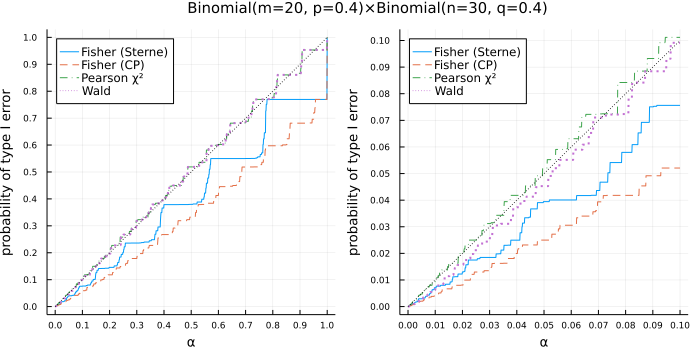

In [55]:
function sim_probabilities_of_type_I_error(m, n, p, q=p;
    ω=p*(1-q)/((1-p)*q), L=10^5)
bina, binc = Binomial(m, p), Binomial(n, q)
p_sterne = similar(zeros(), L)
p_clopper_pearson = similar(zeros(), L)
p_pearson_chisq = similar(zeros(), L)
p_wald = similar(zeros(), L)
@threads for i in 1:L
    a, c = rand(bina), rand(binc)
    b, d = m-a, n-c
    p_sterne[i] = pvalue_or_sterne(a, b, c, d; ω)
    p_clopper_pearson[i] = pvalue_or_clopper_pearson(a, b, c, d; ω)
    p_pearson_chisq[i] = pvalue_or_pearson_chisq(a, b, c, d; ω)
    p_wald[i] = pvalue_or_wald(a, b, c, d; ω)
end
(; p_sterne, p_clopper_pearson, p_pearson_chisq, p_wald)
end

function plot_probabilities_of_type_I_error(m, n, p, q=p;
        ω=p*(1-q)/((1-p)*q), L=10^6, kwargs...)
    (; p_sterne, p_clopper_pearson, p_pearson_chisq, p_wald) =
        sim_probabilities_of_type_I_error(m, n, p, q; ω, L)
    F_sterne = ecdf(p_sterne)
    F_clopper_pearson = ecdf(p_clopper_pearson)
    F_pearson_chisq = ecdf(p_pearson_chisq)
    F_wald = ecdf(p_wald)
    
    x = 0:0.001:1
    tick = 0:0.1:1
    P = plot(; legend=:topleft)
    plot!(x, x -> F_sterne(x); label="Fisher (Sterne)")
    plot!(x, x -> F_clopper_pearson(x); label="Fisher (CP)", ls=:dash)
    plot!(x, x -> F_pearson_chisq(x); label="Pearson χ²", ls=:dashdot)
    plot!(x, x -> F_wald(x); label="Wald", ls=:dot, lw=2)
    plot!(x, identity; label="", c=:black, ls=:dot)
    plot!(; xtick=tick, ytick=tick, tickfontsize=6)
    plot!(; xguide="α", yguide="probability of type I error",
        guidefontsize=9)
    
    x = 0:0.0001:0.1
    tick = 0:0.01:1
    Q = plot(; legend=:topleft)
    plot!(x, x -> F_sterne(x); label="Fisher (Sterne)")
    plot!(x, x -> F_clopper_pearson(x); label="Fisher (CP)", ls=:dash)
    plot!(x, x -> F_pearson_chisq(x); label="Pearson χ²", ls=:dashdot)
    plot!(x, x -> F_wald(x); label="Wald", ls=:dot, lw=2)
    plot!(x, identity; label="", c=:black, ls=:dot)
    plot!(; xtick=tick, ytick=tick, tickfontsize=6)
    plot!(; xguide="α", yguide="probability of type I error",
        guidefontsize=9)
    
    plot(P, Q; size=(700, 350), layout=(1, 2))
    plot!(; plot_title="Binomial(m=$m, p=$p)×Binomial(n=$n, q=$q)",
        plot_titlefontsize=10)
    plot!(; kwargs...)
end

plot_probabilities_of_type_I_error(20, 30, 0.4)

In [56]:
a, b, c, d = 23, 230, 43, 213
@show a, b, c, d
ω = 0.9
@show ω
@show ORhat = a*d/(b*c)
@show SEhat = √(1/a + 1/b + 1/c + 1/d)
@show pvalue = 2ccdf(Normal(), abs(log(ORhat) - log(ω))/SEhat)
α = 0.05
@show α
@show z = quantile(Normal(), 1-α/2)
@show confint = [exp(-z*SEhat)*ORhat, exp(z*SEhat)*ORhat];

(a, b, c, d) = (23, 230, 43, 213)
ω = 0.9
ORhat = (a * d) / (b * c) = 0.49534883720930234
SEhat = √(1 / a + 1 / b + 1 / c + 1 / d) = 0.27527574646299896
pvalue = 2 * ccdf(Normal(), abs(log(ORhat) - log(ω)) / SEhat) = 0.030066296229886037
α = 0.05
z = quantile(Normal(), 1 - α / 2) = 1.9599639845400576
confint = [exp(-z * SEhat) * ORhat, exp(z * SEhat) * ORhat] = [0.288799214494071, 0.8496230536999794]


In [57]:
a, b, c, d = 23, 230, 43, 213
@show a, b, c, d
@show pvalue_or_wald(a, b, c, d; ω=0.9)
@show confint_or_wald(a, b, c, d; α=0.005);

(a, b, c, d) = (23, 230, 43, 213)
pvalue_or_wald(a, b, c, d; ω = 0.9) = 0.030066296229886037
confint_or_wald(a, b, c, d; α = 0.005) = [0.22873266504871012, 1.072739088106872]


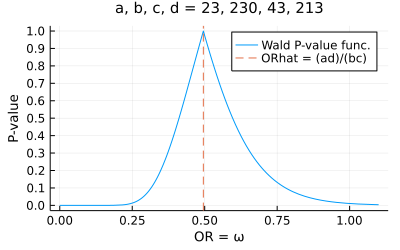

In [58]:
a, b, c, d = 23, 230, 43, 213
plot(ω -> pvalue_or_wald(a,b,c,d; ω), 0.0 ,1.1; label="Wald P-value func.")
vline!([oddsratiohat(a,b,c,d)]; label="ORhat = (ad)/(bc)", ls=:dash)
plot!(; xguide="OR = ω", yguide="P-value")
plot!(; ytick=0:0.1:1)
title!("a, b, c, d = $a, $b, $c, $d")

In [59]:
a, b, c, d = 23, 230, 43, 213
@show riskratiohat(a, b, c, d)
@show oddsratiohat(a, b, c, d)
@show pvalue_rr_wald(a, b, c, d; ρ=0.9)
@show pvalue_or_wald(a, b, c, d; ω=0.9)
@show confint_rr_wald(a, b, c, d; α = 0.05)
@show confint_or_wald(a, b, c, d; α = 0.05);

riskratiohat(a, b, c, d) = 0.5412262156448203
oddsratiohat(a, b, c, d) = 0.49534883720930234
pvalue_rr_wald(a, b, c, d; ρ = 0.9) = 0.03608976031307245
pvalue_or_wald(a, b, c, d; ω = 0.9) = 0.030066296229886037
confint_rr_wald(a, b, c, d; α = 0.05) = [0.3363886834579713, 0.870795692322426]
confint_or_wald(a, b, c, d; α = 0.05) = [0.288799214494071, 0.8496230536999794]


In [60]:
a, b, c, d, ω, α = 23, 230, 43, 213, 0.9, 0.005
@show oddsratiohat(a, b, c, d)
@show pvalue_or_wald(a, b, c, d;ω=0.9)
@show pvalue_or_pearson_chisq(a, b, c, d;ω=0.9)
@show pvalue_or_sterne(a, b, c, d;ω=0.9)
@show pvalue_or_clopper_pearson(a, b, c, d;ω=0.9)
@show confint_or_wald(a, b, c, d; α=0.05)
@show confint_or_pearson_chisq(a, b, c, d; α=0.05)
@show confint_or_sterne(a, b, c, d; α=0.05)
@show confint_or_clopper_pearson(a, b, c, d; α=0.05);

oddsratiohat(a, b, c, d) = 0.49534883720930234
pvalue_or_wald(a, b, c, d; ω = 0.9) = 0.030066296229886037
pvalue_or_pearson_chisq(a, b, c, d; ω = 0.9) = 0.02844011042556404
pvalue_or_sterne(a, b, c, d; ω = 0.9) = 0.034196062301823905
pvalue_or_clopper_pearson(a, b, c, d; ω = 0.9) = 0.03839388251759841
confint_or_wald(a, b, c, d; α = 0.05) = [0.288799214494071, 0.8496230536999794]
confint_or_pearson_chisq(a, b, c, d; α = 0.05) = [0.2901717291680993, 0.8459270313113191]
confint_or_sterne(a, b, c, d; α = 0.05) = [0.2852107966466883, 0.8511784263249226]
confint_or_clopper_pearson(a, b, c, d; α = 0.05) = [0.27543053647333116, 0.873983494501823]


__解答__

1, 0.02844011042556404

2, 0.034196062301823905

3, [0.2901717291680993, 0.8459270313113191]

4, [0.27543053647333116, 0.873983494501823]

## 大問9 10

In [61]:
x=symbols("x")
n=symbols("n")

n

In [62]:
K= cos(x/n)*x^((n/2)-1)

 n           
 ─ - 1       
 2        ⎛x⎞
x     ⋅cos⎜─⎟
          ⎝n⎠

In [63]:
K.integrate(x)

 n           ⎛    n      │     ⎞
 ─           ⎜    ─      │   2 ⎟
 2  ⎛n⎞  ┌─  ⎜    4      │ -x  ⎟
x ⋅Γ⎜─⎟⋅ ├─  ⎜           │ ────⎟
    ⎝4⎠ 1╵ 2 ⎜     n     │    2⎟
             ⎜1/2, ─ + 1 │ 4⋅n ⎟
             ⎝     4     │     ⎠
────────────────────────────────
              ⎛n    ⎞           
           2⋅Γ⎜─ + 1⎟           
              ⎝4    ⎠           

In [64]:
V= x^((n/2)-1)

 n    
 ─ - 1
 2    
x     

In [65]:
V.integrate(x)

⎧    n            
⎪    ─            
⎪    2            
⎪ 2⋅x             
⎨ ────   for n ≠ 0
⎪  n              
⎪                 
⎪log(x)  otherwise
⎩                 